In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
import scipy.optimize as sco
from functools import reduce
from tabulate import tabulate
from matplotlib.ticker import FormatStrFormatter

In [2]:
stocks      = {'AAPL':'Apple', 'AMZN':'Amazon', 'GOOG': 'Google', 'MSFT':'Microsoft', 'TSLA':'Tesla',  'ORCL' : 'Oracle'}
commodities = {'BTC-USD' : 'Bitcoin', 'ETH-USD' : 'Ethereum'}
instruments = {**stocks, **commodities}
tickers     = list(instruments.keys())
instruments_data = {}
N = len(tickers)

start = datetime(2017, 1, 1)
end   = datetime.now()

for ticker, instrument in instruments.items():
    print("Loading data series for instrument {} with ticker = {}".format(instruments[ticker], ticker))
    instruments_data[ticker] = DataReader(ticker, data_source = 'yahoo', start = start, end = end)

Loading data series for instrument Apple with ticker = AAPL
Loading data series for instrument Amazon with ticker = AMZN
Loading data series for instrument Google with ticker = GOOG
Loading data series for instrument Microsoft with ticker = MSFT
Loading data series for instrument Tesla with ticker = TSLA
Loading data series for instrument Oracle with ticker = ORCL
Loading data series for instrument Bitcoin with ticker = BTC-USD
Loading data series for instrument Ethereum with ticker = ETH-USD


In [3]:
for ticker, instrument in instruments.items():
    instruments_data[ticker] = instruments_data[ticker]["Adj Close"]

In [4]:
tr_days = [ len(instr) for _, instr in instruments_data.items() ] 
tr_days = pd.DataFrame(tr_days, index = tickers, columns = ["Trading Days"])
tr_days.T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Trading Days,1041,1041,1041,1041,1041,1041,1510,1510


In [5]:
tr_days_stocks_bonds = instruments_data['AAPL'].groupby([instruments_data['AAPL'].index.year]).agg('count')
tr_days_bitcoin      = instruments_data['BTC-USD'].groupby([instruments_data['BTC-USD'].index.year]).agg('count')
tr_days_palladium    = instruments_data['ETH-USD'].groupby([instruments_data['ETH-USD'].index.year]).agg('count')

tr_days_per_year = pd.DataFrame([tr_days_stocks_bonds,tr_days_bitcoin, tr_days_palladium], index = ["Stocks", "Bitcoin", "Ethereum"])
tr_days_per_year

Date,2017,2018,2019,2020,2021
Stocks,251,251,252,253,34
Bitcoin,365,365,365,362,53
Ethereum,365,365,365,362,53


### 2.5 - Merging Dataframes

In [6]:
# Merging Dataframes
data = list(instruments_data.values())
data_df = reduce(lambda x, y: pd.merge(x, y, left_index = True, right_index = True, how = 'outer'), data).dropna()
data_df.columns = tickers
data_df

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Date,,,,,,,,
2017-01-03,27.459938,753.669983,786.140015,58.538418,43.397999,36.083473,1043.839966,9.725250
2017-01-04,27.429203,757.179993,786.900024,58.276497,45.397999,36.261311,1154.729980,11.251600
2017-01-05,27.568691,780.450012,794.020020,58.276497,45.349998,36.167709,1013.380005,10.254400
2017-01-06,27.876030,795.989990,806.150024,58.781628,45.801998,35.989861,902.200989,10.254700
2017-01-09,28.131361,796.919983,806.650024,58.594547,46.256001,36.532753,902.828003,10.325600
...,...,...,...,...,...,...,...,...
2021-02-16,133.190002,3268.949951,2121.899902,243.139999,796.219971,62.139999,49199.871094,1781.067505
2021-02-17,130.839996,3308.639893,2128.310059,244.199997,798.150024,62.090000,52149.007812,1848.458252
2021-02-18,129.710007,3328.229980,2117.199951,243.789993,787.380005,62.070000,51679.796875,1937.449219


In [7]:
tr_days_per_year = data_df['AAPL'].groupby([data_df['AAPL'].index.year]).agg('count')
tr_days_per_year = pd.DataFrame([tr_days_per_year], index = ["All instruments (merged)"])
tr_days_per_year

Date,2017,2018,2019,2020,2021
All instruments (merged),251,251,252,250,34


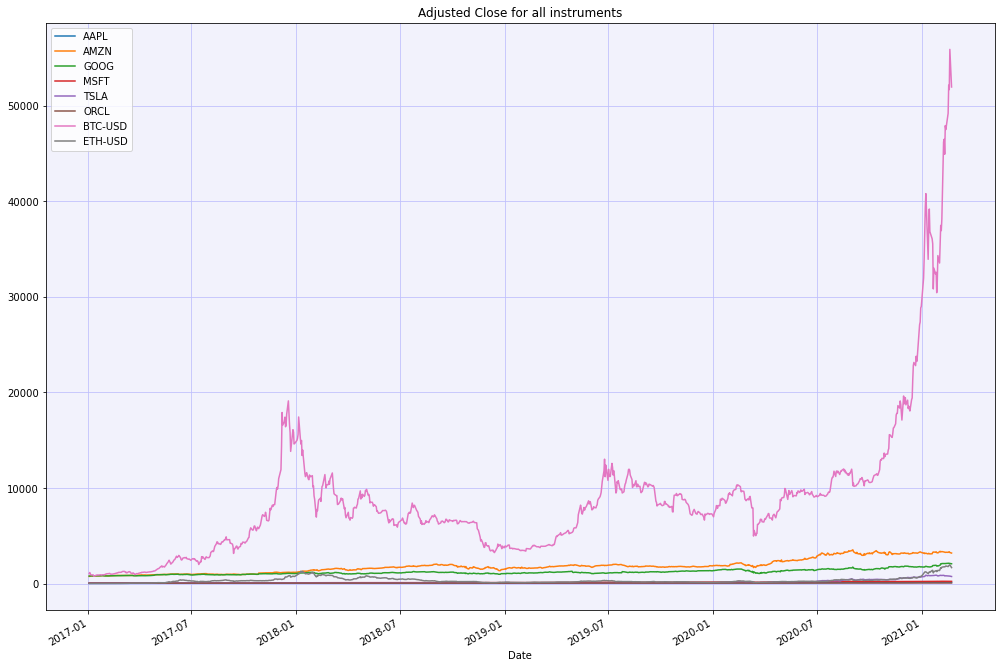

In [8]:
# Plot Adj Close together
fig, ax = plt.subplots(figsize=(17, 12))
data_df.plot(ax = plt.gca(),grid = True)
ax.set_title('Adjusted Close for all instruments')
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))

### Calculate Descriptive Statistics

Daily
A “better” solution, though, would be to plot the information we actually want: the stock’s returns. This involves transforming the data into something more useful for our purposes. There are multiple transformations we could apply

Simple Returns : One transformation would be to consider the stock’s return since the beginning of the period of interest. In other words, we plot:$$r_t = \frac{P_t}{P_0} - 1$$
Log Returns$$r_t = ln\left(\frac{P_t}{P_0}\right)$$
Annual
$$APR = R_{nominal} = r_{N} = ln\left(\frac{P_N}{P_0}\right) = ln\left(\frac{P_N}{P_{N-1}}\cdot \frac{P_{N-1}}{P_{N-2}} \cdot ... \frac{P_1}{P_{0}}\right)$$$$APY = (1 + \frac{APR}{N})^{N} - 1 \longrightarrow R_{effective} = (1 + \frac{R_{nominal} }{N})^{N} - 1$$

### Daily Simple Returns

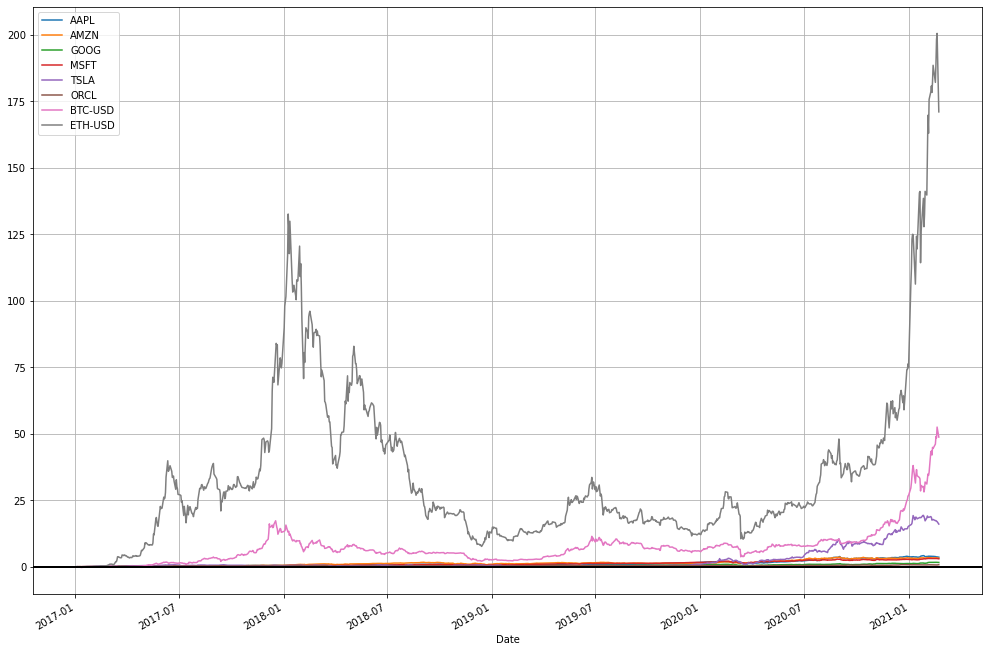

In [9]:
simple_returns = data_df.apply(lambda x: x / x[0] - 1)
simple_returns.plot(grid = True, figsize = (17, 12)).axhline(y = 0, color = "black", lw = 2)

In [10]:
# Daily Log Returns
log_returns = data_df.pct_change()
log_returns

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Date,,,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,-0.001119,0.004657,0.000967,-0.004474,0.046085,0.004928,0.106233,0.156947
2017-01-05,0.005085,0.030732,0.009048,0.000000,-0.001057,-0.002581,-0.122410,-0.088627
2017-01-06,0.011148,0.019912,0.015277,0.008668,0.009967,-0.004917,-0.109711,0.000029
2017-01-09,0.009160,0.001168,0.000620,-0.003183,0.009912,0.015085,0.000695,0.006914
...,...,...,...,...,...,...,...,...
2021-02-16,-0.016104,-0.002673,0.008455,-0.005266,-0.024384,-0.014902,0.035681,-0.033883
2021-02-17,-0.017644,0.012141,0.003021,0.004360,0.002424,-0.000805,0.059942,0.037837
2021-02-18,-0.008636,0.005921,-0.005220,-0.001679,-0.013494,-0.000322,-0.008998,0.048143


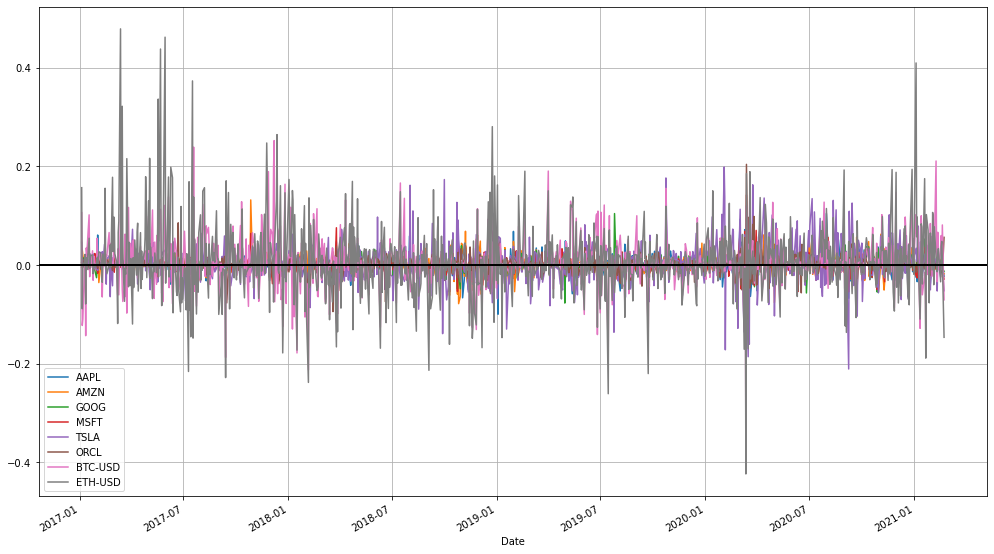

In [11]:
log_returns.plot(grid = True, figsize = (17, 10)).axhline(y = 0, color = "black", lw = 2)

### Annual : APR or $r_{nominal}$

In [12]:
APR = log_returns.groupby([log_returns.index.year]).agg('sum')
APR_avg = APR.mean()
APR

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Date,,,,,,,,
2017,0.407928,0.460880,0.297832,0.345630,0.423272,0.231769,3.073796,5.391401
2018,-0.014373,0.315140,0.029084,0.228574,0.233929,0.002603,-1.043399,-1.124127
2019,0.671478,0.233466,0.284456,0.474615,0.350457,0.196343,0.878215,0.283864
2020,0.708341,0.640714,0.344531,0.451761,2.542280,0.297969,1.665005,2.234973
2021,-0.036262,-0.015098,0.177129,0.057886,0.069335,0.005341,0.667416,0.982119


In [13]:
pd.DataFrame(APR_avg, columns = ['Average APR']).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Average APR,0.347422,0.327021,0.226606,0.311693,0.723855,0.146805,1.048207,1.553646


### Annual : APY or $r_{effective}$

In [14]:
N = np.array(tr_days_per_year.T)
N_total = np.sum(N)

APY = (1  + APR / N )**N - 1
APY_avg = (1  + APR_avg /N_total  )**N_total - 1
APY

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Date,,,,,,,,
2017,0.503201,0.584799,0.346698,0.412544,0.526405,0.260694,20.223892,206.330425
2018,-0.014270,0.370180,0.029510,0.256675,0.263417,0.002606,-0.648510,-0.675883
2019,0.955381,0.262833,0.328825,0.606678,0.419371,0.216852,1.402928,0.328040
2020,1.028587,0.896281,0.410993,0.570436,11.546489,0.346881,4.256602,8.253871
2021,-0.035632,-0.014987,0.193236,0.059542,0.071719,0.005355,0.936631,1.633205


In [15]:
pd.DataFrame(APY_avg, columns = ['Average APY']).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Average APY,0.415332,0.386759,0.254305,0.365672,1.061847,0.158116,1.851022,3.72319


### Risk (Volatility Risk of returns)
Variance $\sigma^2$$$Var(R) = \sigma^2 = \frac{\sum_{t = 1}^{N}(R_t - \bar{R_t})^2}{N}$$
Standard Deviation $\sigma$$$\sigma =\sqrt{\sigma^2} = \sqrt{\frac{\sum_{t = 1}^{N}(R_t - \bar{R_t})^2}{N}}$$where $R_t = $ log price of instrument $i$ at the time $t$

In [16]:
# Standard Deviation
STD       = log_returns.groupby([log_returns.index.year]).agg('std') * np.sqrt(N)
STD_avg   = STD.mean()
std       = log_returns.std()
STD

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Date,,,,,,,,
2017,0.176056,0.209632,0.153610,0.147920,0.353196,0.177480,0.929347,1.499069
2018,0.286851,0.360329,0.280793,0.282078,0.584482,0.254262,0.790631,1.094598
2019,0.261383,0.229098,0.241414,0.198285,0.493199,0.198255,0.673375,0.783045
2020,0.463384,0.384172,0.385093,0.440945,0.895174,0.407247,0.703586,0.960414
2021,0.114624,0.096956,0.125399,0.093054,0.207754,0.084105,0.407218,0.584780


In [17]:
pd.DataFrame(STD_avg, columns = ['Average STD']).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Average STD,0.260459,0.256037,0.237262,0.232456,0.506761,0.22427,0.700831,0.984381


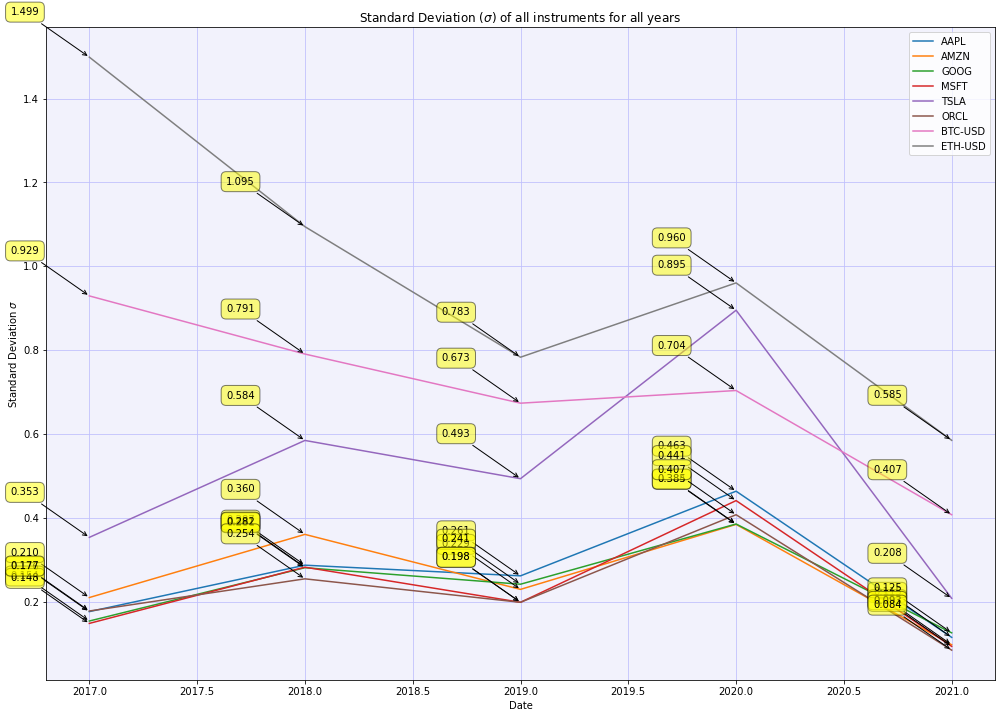

In [18]:
# Visualize standard deviation for all instruments for all years
# configuration
fig, ax = plt.subplots(figsize = (17, 12))
ax.set_title(r"Standard Deviation ($\sigma$) of all instruments for all years")
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))
ax.set_ylabel(r"Standard Deviation $\sigma$")
ax.set_xlabel(r"Years")
STD.plot(ax = plt.gca(),grid = True)

for instr in STD:
    stds = STD[instr]
    years = list(STD.index)
    for year, std in zip(years, stds):
        label = "%.3f"%std
        plt.annotate(label, xy = (year, std), xytext=((-1)*50, 40),textcoords = 'offset points', ha = 'right', va='bottom', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

In [19]:
# Variance
VAR = STD **2
VAR_avg = VAR.mean()
VAR

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Date,,,,,,,,
2017,0.030996,0.043945,0.023596,0.021880,0.124748,0.031499,0.863686,2.247206
2018,0.082283,0.129837,0.078845,0.079568,0.341619,0.064649,0.625097,1.198144
2019,0.068321,0.052486,0.058281,0.039317,0.243245,0.039305,0.453434,0.613160
2020,0.214725,0.147588,0.148297,0.194432,0.801337,0.165850,0.495034,0.922396
2021,0.013139,0.009400,0.015725,0.008659,0.043162,0.007074,0.165826,0.341968


In [20]:
pd.DataFrame(VAR_avg, columns = ['Average VAR']).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Average VAR,0.081893,0.076651,0.064949,0.068771,0.310822,0.061675,0.520615,1.064575


### Visualize Return ($R_{effective}$) vs Risk ($\sigma$)

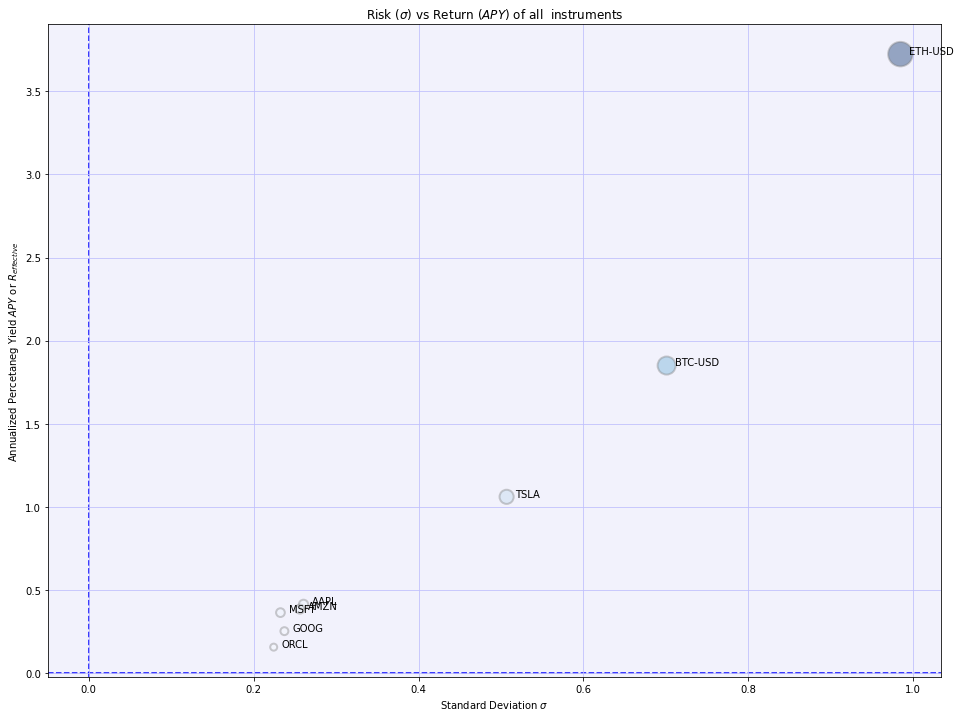

In [21]:
# configuration - generate different colors & sizes
c = [y + x for y, x in zip(APY_avg, STD_avg)]
c = list(map(lambda x : x /max(c), c))
s = list(map(lambda x : x * 600, c))

# plot
fig, ax = plt.subplots(figsize = (16,12))
ax.set_title(r"Risk ($\sigma$) vs Return ($APY$) of all  instruments")
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))
ax.set_xlabel(r"Standard Deviation $\sigma$")
ax.set_ylabel(r"Annualized Percetaneg Yield $APY$ or $R_{effective}$")
ax.scatter(STD_avg, APY_avg, s = s , c = c , cmap = "Blues", alpha = 0.4, edgecolors="grey", linewidth=2)
ax.axhline(y = 0.0,xmin = 0 ,xmax = 5,c = "blue",linewidth = 1.5,zorder = 0,  linestyle = 'dashed')
ax.axvline(x = 0.0,ymin = 0 ,ymax = 40,c = "blue",linewidth = 1.5,zorder = 0,  linestyle = 'dashed')
for idx, instr in enumerate(list(STD.columns)):
    ax.annotate(instr, (STD_avg[idx] + 0.01, APY_avg[idx]))

### Calculate Additional Descriptives

In [22]:
# Configuration & Utility Function for visualization
instruments = list(log_returns.columns)
instruments

['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TSLA', 'ORCL', 'BTC-USD', 'ETH-USD']

In [23]:
def visualize_statistic(statistic, title, limit = 0):
    # configuration
    fig, ax = plt.subplots(figsize = (17, 12))
    ax.set_facecolor((0.95, 0.95, 0.99))
    ax.grid(c = (0.75, 0.75, 0.99), axis = 'y')
    colors = sns.color_palette('Reds', n_colors = len(statistic))
    
    # visualize
    barlist = ax.bar(x = np.arange(len(statistic)), height =  statistic)
    for b, c in zip(barlist, colors):
        b.set_color(c)
    ax.axhline(y = limit, xmin = -1 ,xmax = 1,c = "blue",linewidth = 1.5,zorder = 0,  linestyle = 'dashed')

    # configure more
    for i, v in enumerate(statistic):
        ax.text( i - 0.22,v + 0.01 , str(round(v,3)), color = 'blue', fontweight='bold')
    plt.xticks(np.arange(len(statistic)), instruments)
    plt.title(r"{}for every instrument (i) against market (m) S&P500".format(title))
    plt.xlabel(r"Instrument")
    plt.ylabel(r"{} value".format(title))
    plt.show()

In [24]:
def visualize_model(alpha, beta, data, model):
    fig, axs = plt.subplots(3,3, figsize = (14, 10),  constrained_layout = True)
    # fig.tight_layout()
    idx = 0
    R_m = data["^GSPC"]
    del data["^GSPC"]
    for a, b, instr in zip(alpha, beta, data):
        i, j = int(idx / 3), idx % 3
        axs[i, j].set_title("Model : {} fitted for '{}'".format(model, instr))
        axs[i, j].set_facecolor((0.95, 0.95, 0.99))
        axs[i, j].grid(c = (0.75, 0.75, 0.99))
        axs[i, j].set_xlabel(r"Market (S&P500) log returns")
        axs[i, j].set_ylabel(r"{} log returns".format(instr))
    
        R = data[instr]
        y = a + b * R_m
        axs[i, j].scatter(x = R_m, y = R, label = 'Returns'.format(instr))
        axs[i, j].plot(R_m, y ,color = 'red', label = 'CAPM model')
        idx += 1

### Expanded CAPM (CAPM & Single-Index Model)
$$E[R] - R_f = \alpha + \beta \cdot (E[R_m] - R_f) + \epsilon$$
We calulate $\alpha, \beta$ as followed :

$\beta = \rho_{i,m}\frac{\sigma}{\sigma_m}$
$\alpha = (\overline{E[R]} - R_f) - \beta \cdot (\overline{E[R_m]} - R_f)$
We can also calculate a,b by fitting a linear-regression model (OLS) of the format:$$y = \alpha + \beta x$$

We have 1 feature $x$ : the market premium $x = (E[R_m] - R_f)$. We could have more n features $(x_1,..., x_n)$ making the prediction for the $E[R]$ more accurate (probably?)

In [25]:
# [*] Risk-Free Asset : 13 Week Tbill (^IRX). Get the most recent value
risk_free = DataReader('^IRX', data_source = 'yahoo', start = start, end = end)['Adj Close']
risk_free = float(risk_free.tail(1))

print("Risk-Free rate (Daily T-bill) = {}".format(risk_free))

Risk-Free rate (Daily T-bill) = 0.02500000037252903


### Market $R_m$ : Assume S&P500 (^GSPC)

In [26]:
# [*] Market          : S&P 500 index (^GSPC) | Yahoo Finance for index pricing, '^GSPC' is the underlying for 'SPX' options. 
market             = DataReader('^GSPC', data_source = 'yahoo', start = start, end = end)['Adj Close']
market             = market.rename("^GSPC")
market_log_returns = market.pct_change()
log_returns_total  = pd.concat([log_returns,market_log_returns], axis = 1).dropna()

# Descriptive statistics
# RETURN
log_returns_total = pd.concat([log_returns,market_log_returns], axis = 1).dropna()
APR_total         = log_returns_total.groupby([log_returns_total.index.year]).agg('sum')
APR_avg_total     = APR_total.mean()
APR_avg_market    = APR_avg_total['^GSPC']
# RISK
STD_total         = log_returns_total.groupby([log_returns_total.index.year]).agg('std') * np.sqrt(N)
STD_avg_total     = STD_total.mean()
STD_avg_market    = STD_avg_total['^GSPC']

In [27]:
pd.DataFrame(APR_avg_total, columns = ['Average APR']).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD,^GSPC
Average APR,0.347422,0.327021,0.226606,0.311693,0.723855,0.146805,1.048207,1.553646,0.120067


In [28]:
pd.DataFrame(STD_avg_total, columns = ['Average STD']).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD,^GSPC
Average STD,0.260459,0.256037,0.237262,0.232456,0.506761,0.22427,0.700831,0.984381,0.151791


In [29]:
# Calculate correlation ρ & R squared R^2 between all instruments (i) & market (m)
corr = log_returns.corrwith(market_log_returns)
r_squared = corr ** 2

pd.DataFrame(r_squared, columns = ["R squared"]).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
R squared,0.586877,0.380735,0.595804,0.711297,0.179824,0.488333,0.013379,0.014806


### Apply Expanded CAPM

In [30]:
# Expanded Capital Asset Pricing Model
# E[R] - R_f  = α + β * (E[R_M] - R_f) + 𝜖
# 
# INPUT :  [*] E[R] = log returns, σ = STD
# OUTPUT : [*] α,β

def CAPM():
    # Calculate average Risk Premium for every instrument  
    APR_premium        = APR_avg - risk_free
    APR_market_premium = APR_avg_market - risk_free

    # Calculate α, β
    beta  = corr *  STD_avg / STD_avg_market
    alpha = APR_premium - beta * APR_market_premium 
    return alpha, beta

alpha, beta = CAPM()

In [31]:
pd.DataFrame(alpha,  columns = ["Average α"]).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Average α,0.197454,0.203074,0.086906,0.163906,0.564264,0.02365,0.972435,1.453628


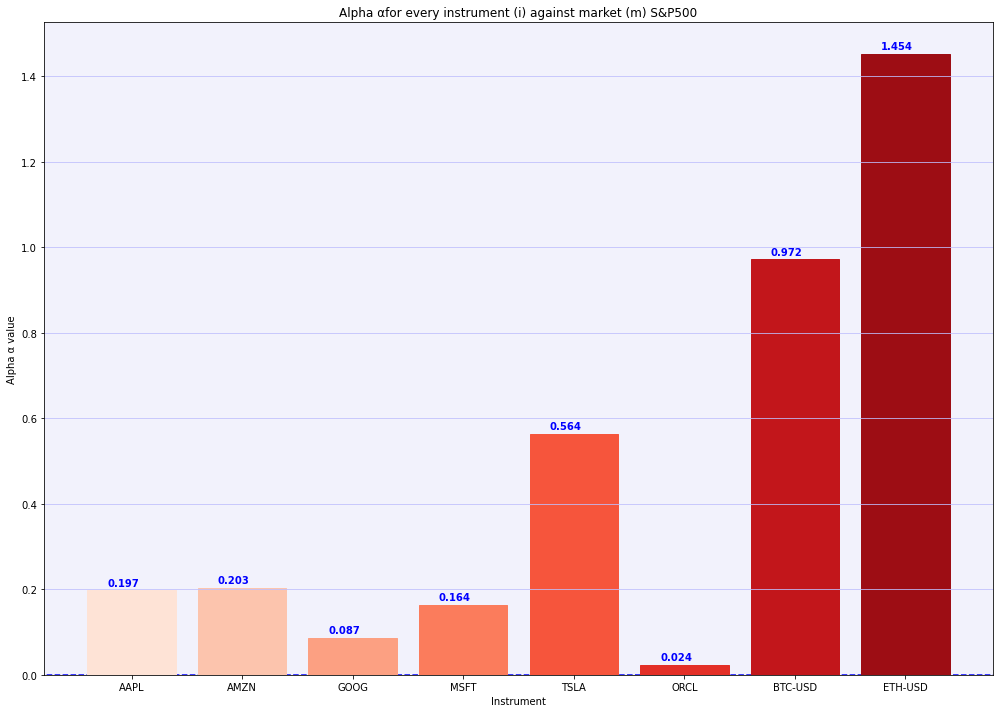

In [32]:
visualize_statistic(alpha.values, "Alpha α")

In [33]:
pd.DataFrame(beta,  columns = ["Average β"]).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Average β,1.314523,1.040804,1.206519,1.29158,1.415735,1.032484,0.534057,0.789106


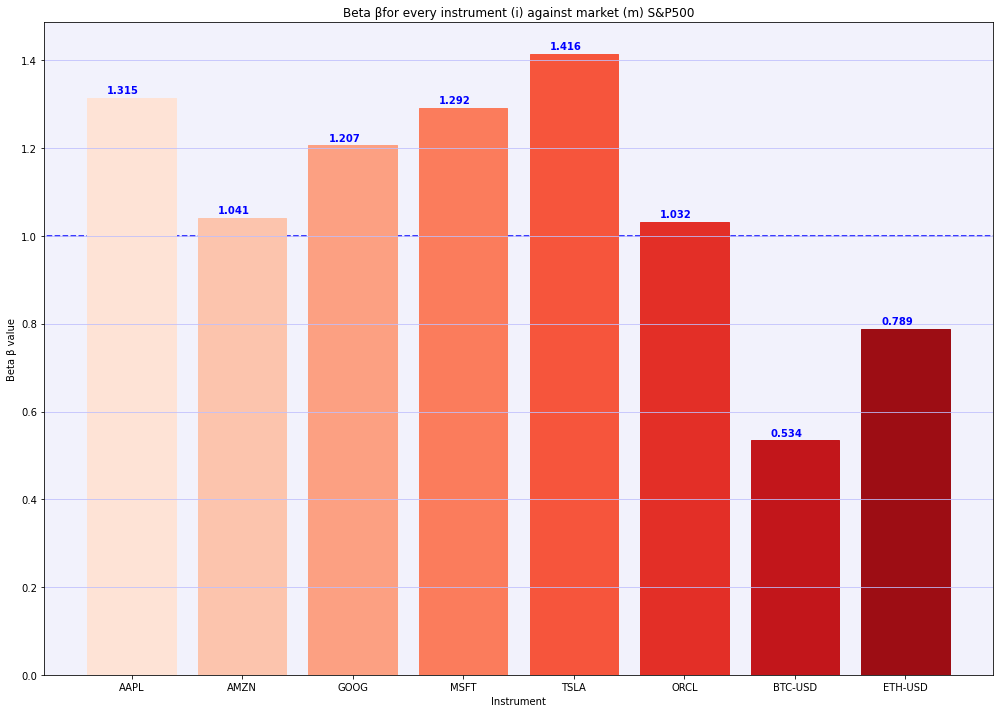

In [34]:
visualize_statistic(beta.values, "Beta β", limit = 1)

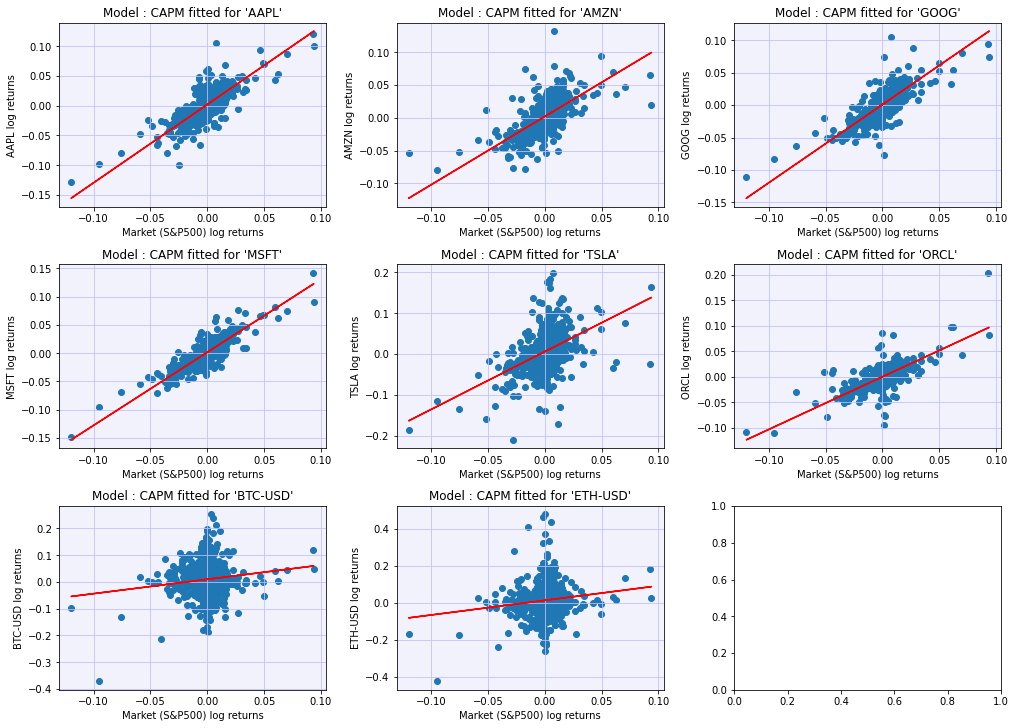

In [35]:
# Visualize data and CAPM model
visualize_model(alpha/100, beta, data = log_returns_total.copy(), model = 'CAPM')

### Apply Linear Regression Model (OLS) $y = \alpha + \beta x$

In [36]:
beta_reg, alpha_reg = np.polyfit(x = log_returns_total['^GSPC'], y = log_returns_total[log_returns.columns], deg = 1)

pd.DataFrame(alpha_reg,  index = log_returns.columns ,columns = ["Average α"]).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Average α,0.000987,0.001041,0.000476,0.00081,0.002746,0.000164,0.004791,0.007094


In [37]:
pd.DataFrame(beta_reg,  index = log_returns.columns ,columns = ["Average β"]).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Average β,1.188554,0.925036,1.065586,1.197156,1.285413,0.939425,0.454915,0.685722


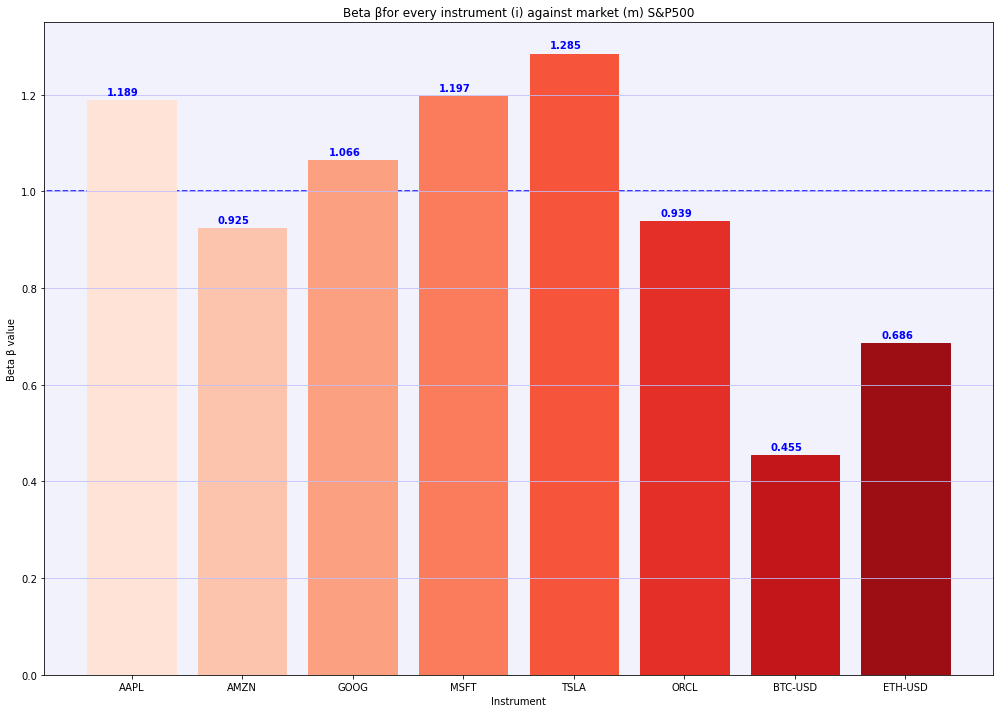

In [38]:
visualize_statistic(beta_reg, "Beta β", limit = 1)

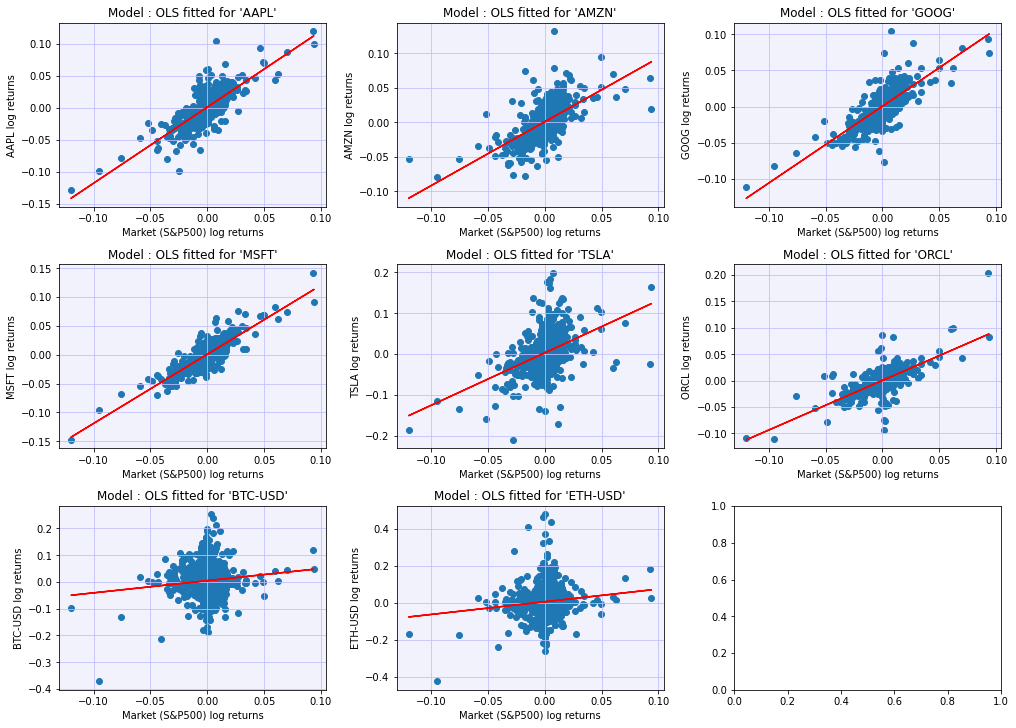

In [39]:
# Visualize data and OLS model
visualize_model(alpha_reg, beta_reg, data = log_returns_total.copy(), model = 'OLS')

In [40]:
portfolios = {
    "#1 dummy (risky)" : {"Return E[R]" : 0, "Risk σ" : 0, "Sharpe Ratio SR" : 0},          
    "#1 dummy (total)" : {"Return E[R]" : 0, "Risk σ" : 0, "Sharpe Ratio SR" : 0}, 
    "#2 optimized max sr (risky)" : {"Return E[R]" : 0, "Risk σ" : 0, "Sharpe Ratio SR" : 0},
    "#2 optimized max sr (total)" : {"Return E[R]" : 0, "Risk σ" : 0, "Sharpe Ratio SR" : 0},
    "#2 optimized min σ (risky)" : {"Return E[R]" : 0, "Risk σ" : 0, "Sharpe Ratio SR" : 0},
    "#2 optimized min σ (total)" : {"Return E[R]" : 0, "Risk σ" : 0, "Sharpe Ratio SR" : 0}
}

### Portfolio #1 (the dummy portfolio)

In [41]:
# WEIGHTS, RETURN, RISK
cov = APR.cov()
weights = np.array([ 0.8/ 6] * 6  + [ 0.1 / 2] * 2)
expected_return = np.sum(APR_avg * weights)
expected_risk   = np.sqrt( np.dot(weights.T , np.dot(cov, weights)) ) 

# RISKY PORTFOLIO
portfolios["#1 dummy (risky)"]["Return E[R]"]     = expected_return
portfolios["#1 dummy (risky)"]["Risk σ"]          = expected_risk
portfolios["#1 dummy (risky)"]["Sharpe Ratio SR"] = (expected_return - risk_free) / expected_risk

# TOTAL PORTFOLIO
total_expected_return = 0.9 * expected_return + 0.1 * risk_free
total_expected_risk   = 0.9 * expected_risk
portfolios["#1 dummy (total)"]["Return E[R]"]     = total_expected_return
portfolios["#1 dummy (total)"]["Risk σ"]          = total_expected_risk
portfolios["#1 dummy (total)"]["Sharpe Ratio SR"] = (total_expected_return - risk_free) / total_expected_risk

portfolios_df = pd.DataFrame(portfolios).T
portfolios_df

,Return E[R],Risk σ,Sharpe Ratio SR
#1 dummy (risky),0.407880,0.371756,1.029921
#1 dummy (total),0.369592,0.334581,1.029921
#2 optimized max sr (risky),0.000000,0.000000,0.000000
#2 optimized max sr (total),0.000000,0.000000,0.000000
#2 optimized min σ (risky),0.000000,0.000000,0.000000
#2 optimized min σ (total),0.000000,0.000000,0.000000


### Portfolio #2 (the optimized portfolio)

In [42]:
# Portfolio Simulation
num_portfolios = 10000
generated_portfolios = []

for idx in range(num_portfolios):
    # select random weights for portfolio holdings & rebalance weights to sum to 1
    weights = np.array(np.random.random(8))
    weights /= np.sum(weights)

    # calculate return, risk, sharpe ratio
    expected_return = np.sum(APR_avg * weights)
    expected_risk   = np.sqrt( np.dot(weights.T , np.dot(cov, weights)) ) 
    sharpe_ratio    = ( expected_return - risk_free) / expected_risk

    # store the result
    generated_portfolios.append([ expected_return, expected_risk, sharpe_ratio, weights] )

# Locate the 2 'special' portfolios 1) maximum sharpe ratio 2) minimum risk
maximum_sr_portfolio   = sorted(generated_portfolios, key = lambda x : -x[2])[0]
minimum_risk_portfolio = sorted(generated_portfolios, key = lambda x : x[1])[0]
max_sr = maximum_sr_portfolio[2]

max_sr_weights = pd.DataFrame(maximum_sr_portfolio[3], index = log_returns.columns ,columns = ["Optimal Weights  #2 optimized max sr "]).T
min_risk_weights = pd.DataFrame(minimum_risk_portfolio[3], index = log_returns.columns ,columns = ["Optimal Weights  #2 optimized min σ "]).T

In [43]:
max_sr_weights

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Optimal Weights #2 optimized max sr,0.124885,0.327972,0.077089,0.326414,0.003623,0.115636,0.02179,0.002592


In [44]:
min_risk_weights

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Optimal Weights #2 optimized min σ,0.110612,0.193576,0.194904,0.184695,0.006774,0.284515,0.01773,0.007194


In [45]:
# RISKY PORTFOLIOS
portfolios["#2 optimized max sr (risky)"]["Return E[R]"]     = maximum_sr_portfolio[0]
portfolios["#2 optimized max sr (risky)"]["Risk σ"]          = maximum_sr_portfolio[1]
portfolios["#2 optimized max sr (risky)"]["Sharpe Ratio SR"] = (maximum_sr_portfolio[0] - risk_free) / maximum_sr_portfolio[1]
portfolios["#2 optimized min σ (risky)"]["Return E[R]"]      = minimum_risk_portfolio[0]
portfolios["#2 optimized min σ (risky)"]["Risk σ"]           = minimum_risk_portfolio[1]
portfolios["#2 optimized min σ (risky)"]["Sharpe Ratio SR"]  = (minimum_risk_portfolio[0] - risk_free) / minimum_risk_portfolio[1]

# TOTAL PORTFOLIOS
total_expected_return = 0.9 * maximum_sr_portfolio[0] + 0.1 * risk_free
total_expected_risk   = 0.9 * maximum_sr_portfolio[1]
portfolios["#2 optimized max sr (total)"]["Return E[R]"]     = total_expected_return
portfolios["#2 optimized max sr (total)"]["Risk σ"]          = total_expected_risk
portfolios["#2 optimized max sr (total)"]["Sharpe Ratio SR"] = (total_expected_return - risk_free) / total_expected_risk
total_expected_return = 0.9 * minimum_risk_portfolio[0] + 0.1 * risk_free
total_expected_risk   = 0.9 * minimum_risk_portfolio[1]
portfolios["#2 optimized min σ (total)"]["Return E[R]"]      = total_expected_return
portfolios["#2 optimized min σ (total)"]["Risk σ"]           = total_expected_risk
portfolios["#2 optimized min σ (total)"]["Sharpe Ratio SR"]  = (total_expected_return - risk_free) / total_expected_risk

In [46]:
portfolios_df = pd.DataFrame(portfolios).T
portfolios_df

,Return E[R],Risk σ,Sharpe Ratio SR
#1 dummy (risky),0.407880,0.371756,1.029921
#1 dummy (total),0.369592,0.334581,1.029921
#2 optimized max sr (risky),0.316317,0.213345,1.365473
#2 optimized max sr (total),0.287185,0.192011,1.365473
#2 optimized min σ (risky),0.279901,0.199219,1.279499
#2 optimized min σ (total),0.254410,0.179297,1.279499


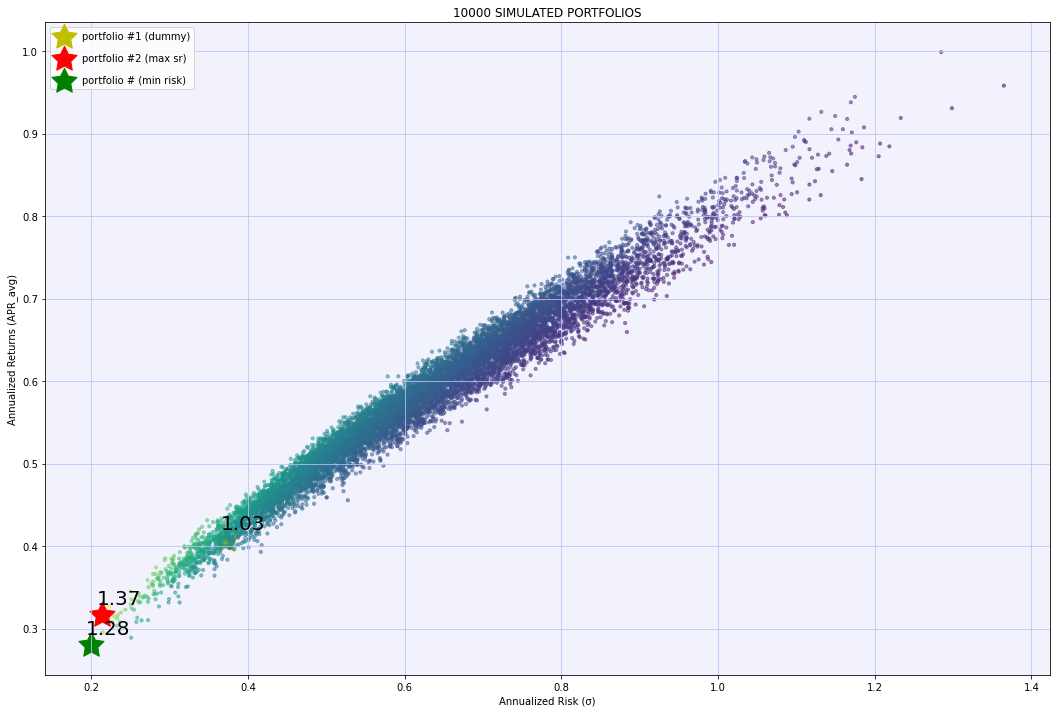

In [47]:
# plot the 2 optimized portfolios along with the rest 9998
def plot_simulation(CAL = None, INSTRUMENTS = None):
    fig, ax = plt.subplots(figsize = (18, 12))
    ax.set_facecolor((0.95, 0.95, 0.99))
    ax.grid(c = (0.75, 0.75, 0.99))
    
    # portfolio #1
    ret  = portfolios["#1 dummy (risky)"]["Return E[R]"]
    risk = portfolios["#1 dummy (risky)"]["Risk σ"]
    sr   = (ret - risk_free) / risk
    ax.scatter(risk, ret, marker = (5,1,0), color = 'y', s = 700, label = 'portfolio #1 (dummy)')
    ax.annotate(round(sr, 2), (risk - 0.006, ret + 0.013),  fontsize = 20, color = 'black')
 
    # portfolio #2
    ret, risk, sr = [x[0] for x in generated_portfolios], [x[1] for x in generated_portfolios], [x[2] for x in generated_portfolios]
    ax.scatter(risk, ret, c = sr, cmap = 'viridis', marker = 'o', s = 10, alpha = 0.5)
    ax.scatter(maximum_sr_portfolio[1], maximum_sr_portfolio[0],marker = (5,1,0),color = 'r',s = 700, label = 'portfolio #2 (max sr)')
    ax.annotate(round(maximum_sr_portfolio[2], 2), (maximum_sr_portfolio[1]  - 0.006,maximum_sr_portfolio[0] + 0.013), fontsize = 20, color = 'black')
    ax.scatter(minimum_risk_portfolio[1], minimum_risk_portfolio[0], marker = (5,1,0), color = 'g',s = 700,  label = 'portfolio # (min risk)')
    ax.annotate(round(minimum_risk_portfolio[2], 2), (minimum_risk_portfolio[1]  - 0.006,minimum_risk_portfolio[0] + 0.013), fontsize = 20, color = 'black')

    if INSTRUMENTS : 
        ax.scatter(STD_avg, APR_avg, s = s , c = c , cmap = "Blues", alpha = 0.4, edgecolors = "grey", linewidth = 2)
        for idx, instr in enumerate(list(STD.columns)):
            sr = round((APR_avg[idx] - risk_free) / STD_avg[idx] , 2)
            ax.annotate(instr, (STD_avg[idx] + 0.01, APR_avg[idx]))
            ax.annotate(sr, (STD_avg[idx] - 0.005 , APR_avg[idx] + 0.015))

    ax.set_title('10000 SIMULATED PORTFOLIOS')
    ax.set_xlabel('Annualized Risk (σ)')
    ax.set_ylabel('Annualized Returns (APR_avg)')
    ax.legend(labelspacing = 1.2)

plot_simulation()

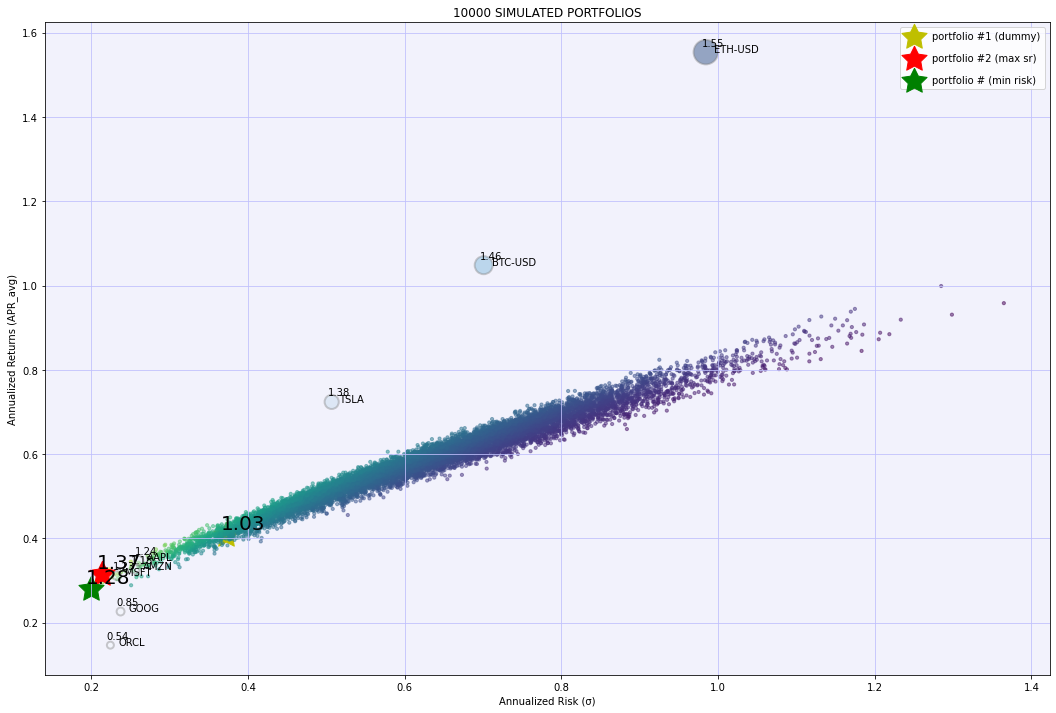

In [48]:
plot_simulation(CAL = None, INSTRUMENTS = 'yes')

### Utility Function
$$U = E[r] - \frac{1}{2}A\sigma^2$$

In [49]:
A = np.linspace(0, 10, 10)
utility_dummy    = portfolios["#1 dummy (total)"]["Return E[R]"] - 1/2 * A * portfolios["#1 dummy (total)"]["Risk σ"] ** 2
utility_max_sr   = portfolios["#2 optimized max sr (total)"]["Return E[R]"] - 1/2 * A * portfolios["#2 optimized max sr (total)"]["Risk σ"] ** 2
utility_min_risk = portfolios["#2 optimized min σ (total)"]["Return E[R]"] - 1/2 * A * portfolios["#2 optimized min σ (total)"]["Risk σ"] ** 2

In [50]:
# Final Evaluation
portfolio = portfolios["#2 optimized max sr (total)"]
ret       = portfolio['Return E[R]']
risk      = portfolio['Risk σ']
sr        = portfolio['Sharpe Ratio SR']
utility   = ret - 1/2 * 3 * risk ** 2

portfolio = pd.DataFrame([str(round(ret * 100, 2)) + "%", str(round(risk * 100, 2)) + "%", sr, str(round(utility * 100, 2) ) + "%"], index = ['Return E[R]', 'Risk σ', 'Sharpe Ratio SR', 'Utility U'] ,columns = ["Portfolio #2 optimized max sr "]).T
portfolio

,Return E[R],Risk σ,Sharpe Ratio SR,Utility U
Portfolio #2 optimized max sr,28.72%,19.2%,1.36547,23.19%
